## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import skimage
import cv2

### Choosing a dataset

Prague grayscale

In [2]:
data_path = "data/Prague_Grayscale_small/"
dataset_size = 20

imgs = [] ; masks = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))

Prague Colour


In [5]:
data_path = "data/Prague_Colour_small/"
dataset_size = 20

imgs = [] ; masks = []
for i in range(1,dataset_size+1):
    imgs.append(skimage.io.imread(data_path + f'tm{i}_1_1.png'))
    masks.append(skimage.io.imread(data_path + f'mask{i}_1.png'))

PASTIS

In [ ]:
data_path = "data/PASTIS_small/"
dataset_size = 20

imgs = [] ; masks = [] ; masks2 = []
for i in range(dataset_size):
    img = np.load(data_path + f"DATA/S2_100{i//10}{i%10}.npy")[1,1,:,:]
    imgs.append(np.squeeze(img))
    masks.append(np.load(data_path + f"ANNOTATIONS/ParcelIDs_100{i//10}{i%10}.npy"))

Patchwork

In [22]:
data_path = "patchworks/"
label_path = "patchworksgt/"
dataset_size = 10

imgs = [] ; masks = [] ; masks2 = []
for i in range(dataset_size):
    imgs.append(skimage.io.imread(data_path + f"patchwork{i+1}.png"))
    masks.append(skimage.io.imread(label_path + f"patchworkgt{i+1}.png"))

In [ ]:
print(imgs[0].shape)
print(masks[0].shape)

(128, 128)
(128, 128)
(128, 128)


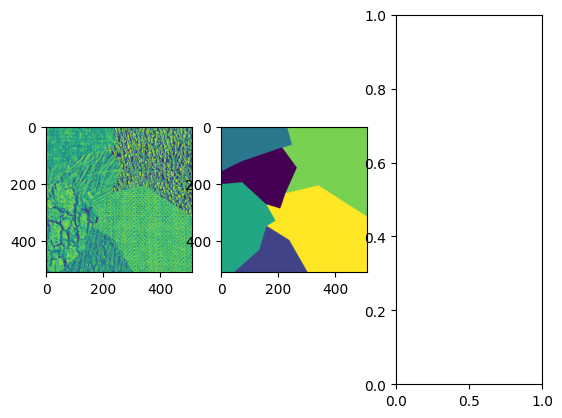

In [9]:
fig, axes = plt.subplots(1,3)
axes[0].imshow(imgs[0])
axes[1].imshow(masks[0])
# axes[2].imshow(masks2[0])


## Arivazhagan & Ganesan, 2003

Select specific image in the data (optional)

In [6]:
idx = 2

imgs = [cv2.cvtColor(imgs[idx],cv2.COLOR_RGB2GRAY)] # Uncomment if using a color dataset (and comment other line)
# imgs = [imgs[idx]] 
masks = [masks[idx]]

Iterate over all selected data

In [7]:
from skimage.feature import graycomatrix
from skimage.util import view_as_windows
from skimage.filters import threshold_otsu
from skimage.morphology import disk, skeletonize
from skimage.filters.rank import mean

def get_features(C):
    """
    Compute features based on co-occurence matrix
    
    :param C: Normalized GLCM (16x16)
    """
    n, k = C.shape

    # Re-indexing to fit paper notation
    i = np.arange(1, n+1).reshape(-1, 1)
    j = np.arange(1, k+1).reshape(1, -1)

    # Means
    mx = np.sum(i * C)
    my = np.sum(j * C)

    # Contrast
    contrast = np.sum((i - j) ** 2 * C)

    # Cluster shade & Prominence
    v = (i - mx + j - my)
    shade = np.sum((v ** 3) * C)
    prominence = np.sum((v ** 4) * C)

    return contrast, shade, prominence


def compute_wcf_features(band):
    """
    Get paper features for a specific WCF band
    
    :param band: Block wavelet subband (LL, HL, etc) as numpy array
    """
    # Normalizing and quantifying (16 levels)
    band = band - band.min()
    band = band / (band.max() + 1e-12)
    band = (band * 15).astype(np.uint8)

    C = graycomatrix(
        band,
        distances=[1],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
        levels=16,
        symmetric=True,
        normed=True
    )

    feats = np.zeros((4, 3))
    for a in range(4):
        feats[a] = get_features(C[:, :, 0, a])

    return feats.mean(axis=0)


def extract_blocks(img, block_size=64):
    """
    Extract subframes from the image
    """
    return view_as_windows(img, (block_size, block_size))


def extract_block_features(blocks, wavelet='db4'):
    """
    Get features for all blocks
    
    :param blocks: subframes list
    :param wavelet: wavelet used (see pywt.wvedec2 documentation)
    """
    nbx, nby = blocks.shape[:2]

    feats = np.zeros((nbx, nby, 4, 3))  # LL, LH, HL, HH × (c,s,p)

    for i in range(nbx):
        for j in range(nby):
            LL, (LH, HL, HH) = pywt.wavedec2(blocks[i, j], wavelet, level=1)

            feats[i, j, 0] = compute_wcf_features(LL)
            feats[i, j, 1] = compute_wcf_features(LH)
            feats[i, j, 2] = compute_wcf_features(HL)
            feats[i, j, 3] = compute_wcf_features(HH)

    return feats

def normalize_linear(x, xmax):
    return np.zeros_like(x) if xmax == 0 else 255 * x / xmax

def normalize_log(x, xmax):
    return np.zeros_like(x) if xmax == 0 else 255 * np.log1p(np.abs(x)) / np.log1p(np.abs(xmax)) # log(1+|x|)

def compute_segmentation_band(feats):
    """
    Compute segmentation band once features are extracted
    
    :param feats: (nbx, nby, 4 (subbands), 3 (features))
    """
    nbx, nby = feats.shape[:2]

    seg = np.zeros((nbx, nby))

    for sb in range(4):
        c = feats[:, :, sb, 0]
        s = feats[:, :, sb, 1]
        p = feats[:, :, sb, 2]

        cN = normalize_linear(c, c.max())
        sN = normalize_log(s, s.max())
        pN = normalize_log(p, p.max())

        S = cN + sN + pN

        seg[:-1, :] += np.abs(S[:-1, :] - S[1:, :])
        seg[:, :-1] += np.abs(S[:, :-1] - S[:, 1:])

    return seg


def post_process(seg, img_shape, blk_size=64):
    """
    Filtering and skeletonizing
    
    :param seg: Segmentation band
    :param img_shape: Subject image shape
    :param blk_size: Size of the subframes
    """
    H, W = img_shape
    seg_pix = np.zeros((H, W))
    weight = np.zeros((H, W))

    for i in range(seg.shape[0]):
        for j in range(seg.shape[1]):
            seg_pix[i:i+blk_size, j:j+blk_size] += seg[i, j]
            weight[i:i+blk_size, j:j+blk_size] += 1

    seg_pix /= weight

    # Disk filtering
    seg_f = mean(seg_pix.astype(np.uint8), disk(3))

    thresh = threshold_otsu(seg_f)
    seg_bin = seg_f > thresh

    return skeletonize(seg_bin)

block_size = 64

def texture_segmentation(img,block_size):
    blocks = extract_blocks(img, block_size)
    feats = extract_block_features(blocks,wavelet='haar')
    seg = compute_segmentation_band(feats)
    return post_process(seg, img.shape,block_size)


### SEGMENTATION (>7 min for 1 image : caution)
seg_imgs = []
for img in imgs:
    seg_imgs.append(texture_segmentation(img,block_size))
# seg_imgs.append(texture_segmentation(imgs[0]))


Plot

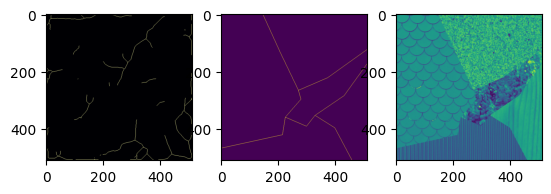

In [8]:

fig, axes = plt.subplots(ncols=3)
# idx = np.random.randint(0,20)
idx = 0
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score (in the end not used)
# F1 = []
# for i in range(len(seg_imgs)):
#     TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
#     FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
#     FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


#     F1.append(2*TP / (2*TP + FP + FN))

# print(f'Mean F1 : {np.mean(F1)}')
# print(f'F1 std : {np.std(F1)}')

# Test with classical techniques (not conclusive)

## Multi Otsu

Mean F1 : 0.0
F1 std : 0.0


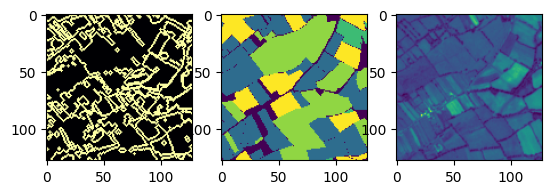

In [14]:
seg_imgs = []
for img in imgs:
    smth_img = skimage.filters.median(img)
    threshs = skimage.filters.threshold_multiotsu(smth_img)
    seg = np.digitize(img,bins=threshs)
    # mask = np.zeros(seg.shape)
    # for i in range(len(threshs)):
    #     contours = skimage.measure.find_contours(seg,level=i)
    #     for contour in contours:
    #         mask[contour.astype(np.int32)] += 1
    seg = skimage.morphology.closing(seg)
    mask = skimage.segmentation.find_boundaries(seg)
    seg_imgs.append(mask)

fig, axes = plt.subplots(ncols=3)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(masks[idx])
axes[2].imshow(imgs[idx])

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    TP = np.sum((masks[i] == 1) & (seg_imgs[i] == 1))
    FN = np.sum((masks[i] == 1) & (seg_imgs[i] == 0))
    FP = np.sum((masks[i] == 0) & (seg_imgs[i] == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')


## SLIC

Mean F1 : 0.0
F1 std : 0.0


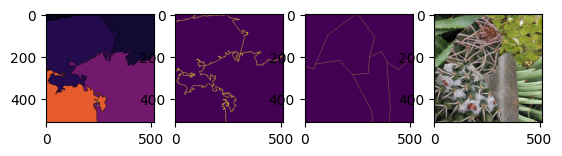

In [6]:
from skimage.segmentation import slic

seg_imgs = []
seg_masks = []
for img in imgs:

    segments = slic(img,n_segments = 10,compactness = 20)
    # segments = slic(img,n_segments = 10,compactness = 10,channel_axis=None)
    mask = skimage.segmentation.find_boundaries(segments)
    seg = skimage.measure.label(mask,background=1)
    seg_imgs.append(seg)
    seg_masks.append(mask)

# F1 score
F1 = []
for i in range(len(seg_imgs)):
    true_mask = skimage.morphology.dilation(masks[i],skimage.morphology.disk(3))
    pred_mask = skimage.morphology.dilation(seg_imgs[i],skimage.morphology.disk(3))
    TP = np.sum((true_mask == 1) & (pred_mask == 1))
    FN = np.sum((true_mask == 1) & (pred_mask == 0))
    FP = np.sum((true_mask == 0) & (pred_mask == 1))


    F1.append(2*TP / (2*TP + FP + FN))

print(f'Mean F1 : {np.mean(F1)}')
print(f'F1 std : {np.std(F1)}')

fig, axes = plt.subplots(ncols=4)
idx = np.random.randint(0,20)
axes[0].imshow(seg_imgs[idx], cmap='inferno')
axes[1].imshow(seg_masks[idx])
axes[2].imshow(masks[idx])
axes[3].imshow(imgs[idx])

## Gabor Filters

C:\Users\yannc\AppData\Local\Temp\ipykernel_28068\120675291.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(4,4)


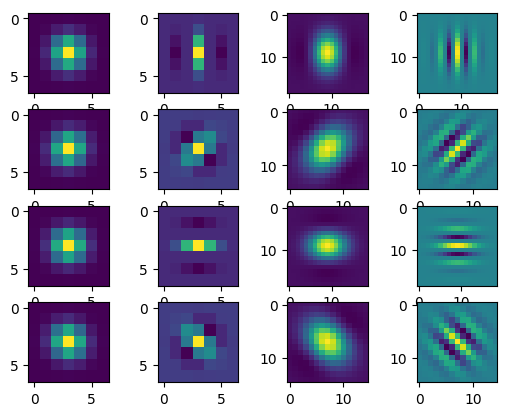

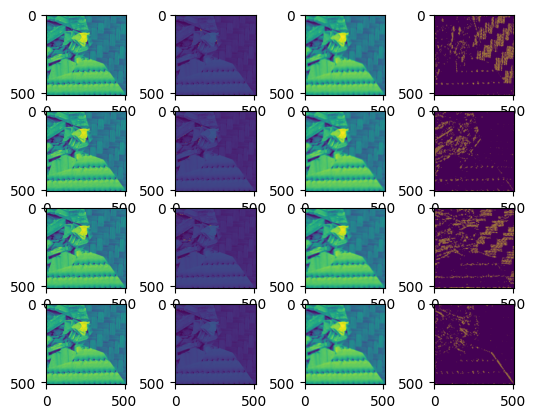

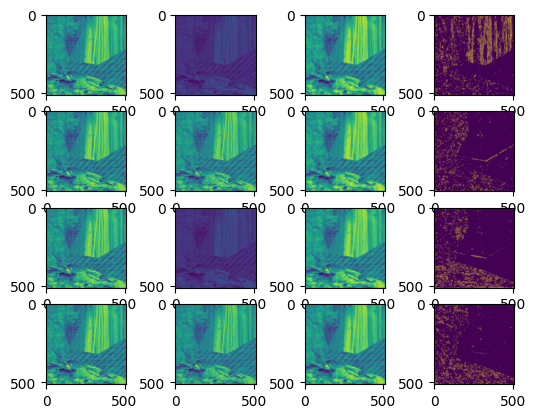

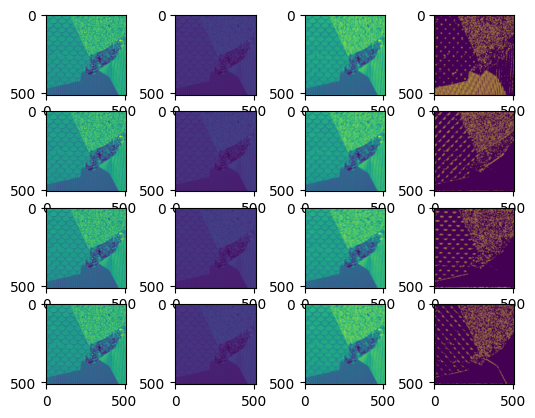

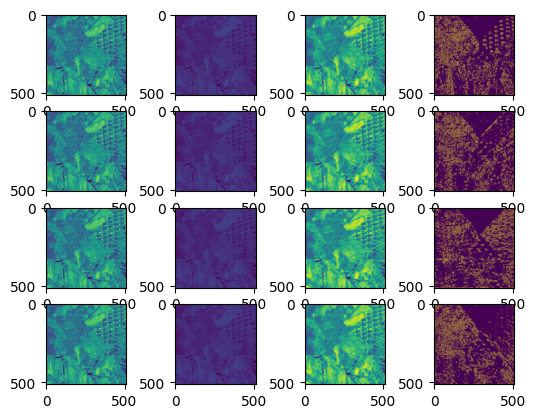

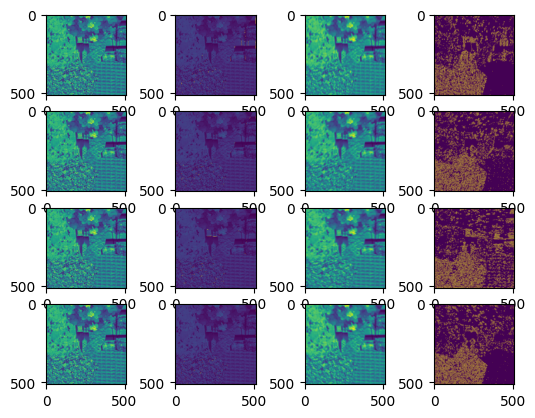

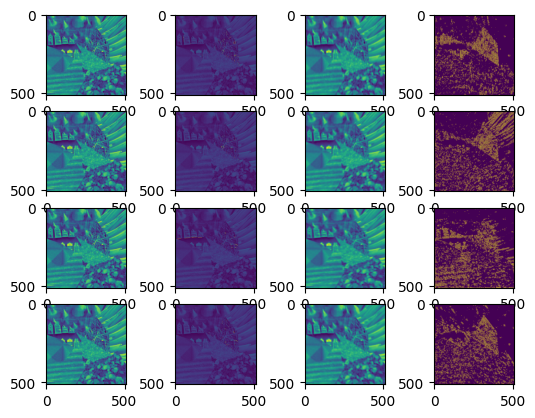

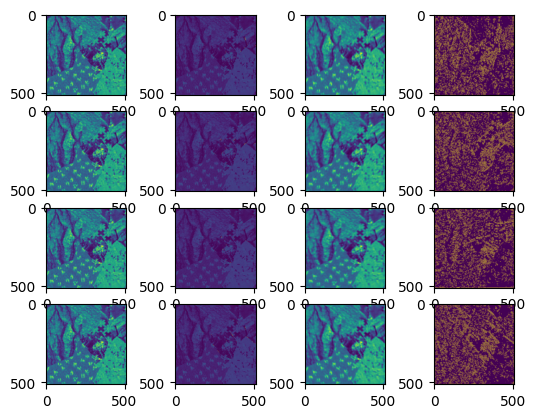

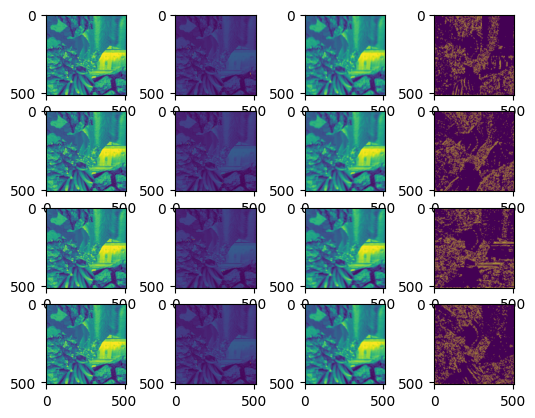

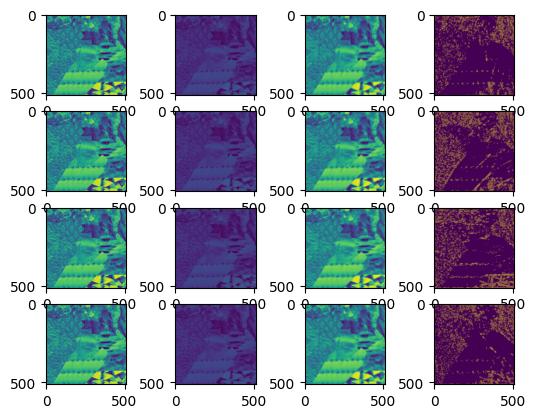

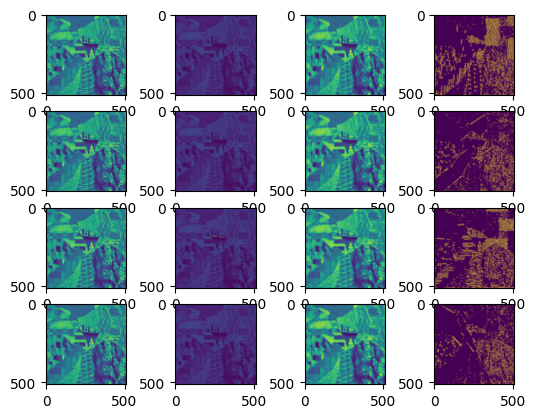

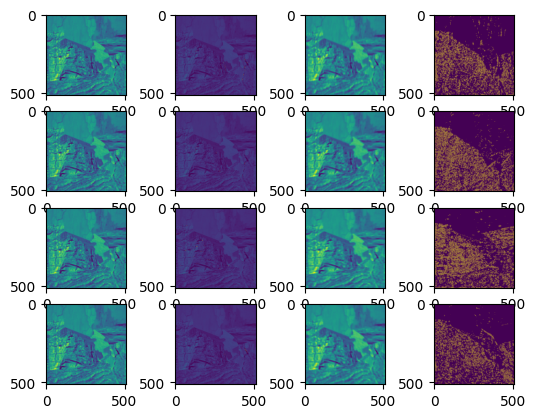

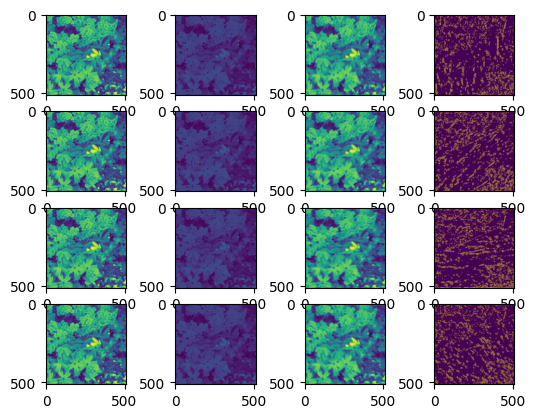

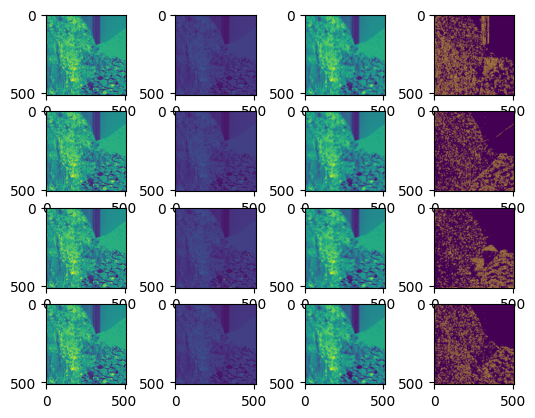

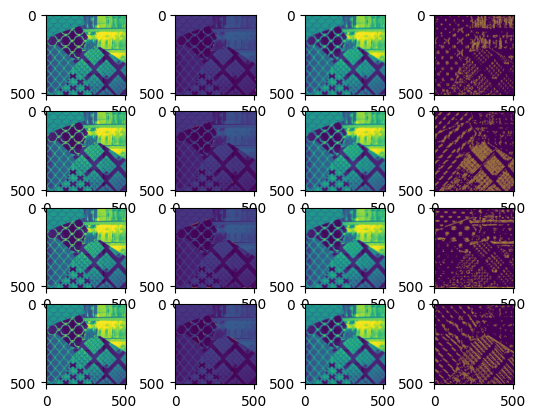

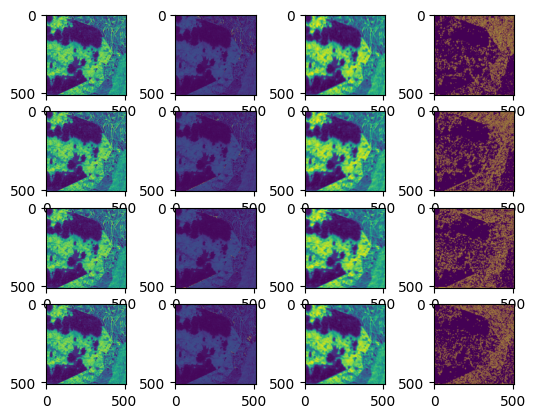

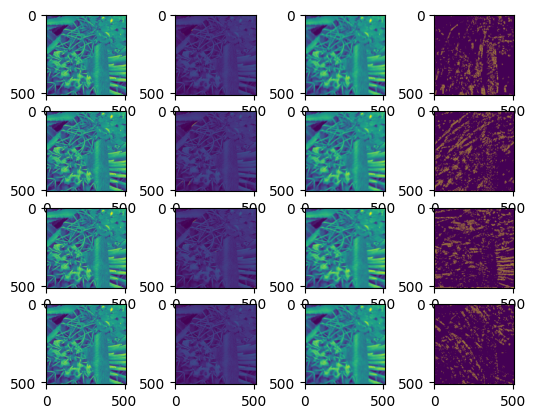

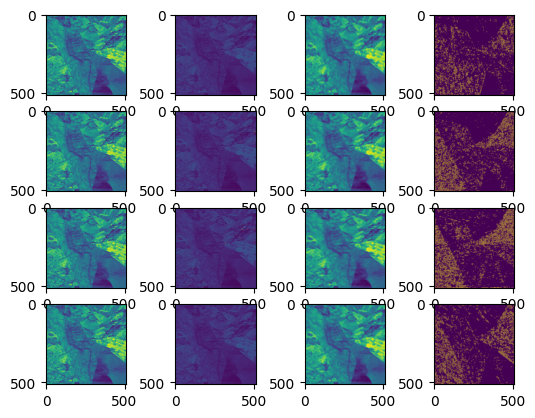

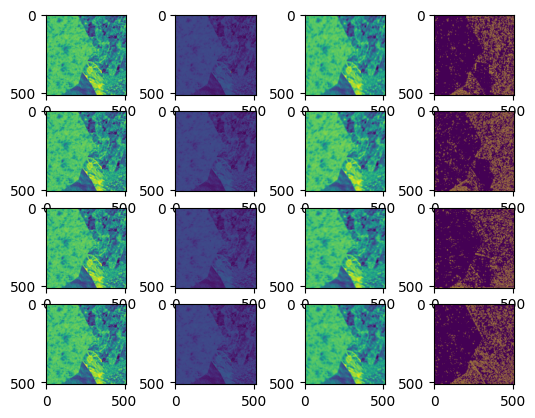

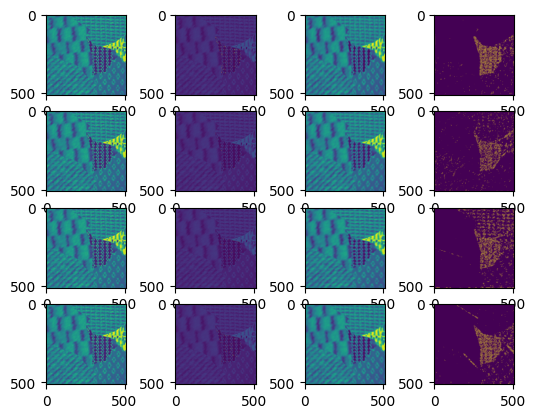

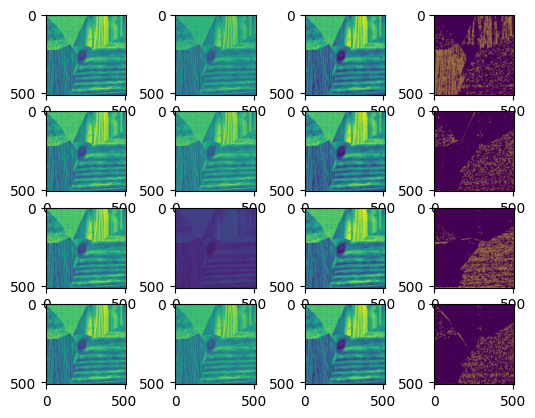

In [5]:
from skimage.filters import gabor_kernel
from scipy.ndimage import convolve

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4.0 * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(
                gabor_kernel(frequency, theta=theta, sigma_x=sigma, sigma_y=sigma)
            )
            kernels.append(kernel)

fig, axes = plt.subplots(4,4)
c = 0
for i in range(4):
    for j in range(4):
        axes[i,j].imshow(kernels[c])
        c+=1

seg_imgs = []
for img in imgs:
    
    filtered = []
    for k, kernel in enumerate(kernels):
        filtered.append(convolve(img,kernel,mode='wrap'))

    fig, axes = plt.subplots(4,4)
    c=0
    for i in range(4):
        for j in range(4):
            axes[i,j].imshow(filtered[c])
            c+=1
